# Ames House Price Data - Random Forest Model

> Juptyer notebook, running a Julia 0.5.2 kernel, with the help of Machine Learning modules written by the author

*In this section we build a random forest regression model using just the 11 most important features, and include Breiman's bagging of patterns. More detail is provided here than for the other models*.

Estimated 95% confidence interval for log-RMS error of Sale Price predictions for the tuned random forest model: 

    0.147 ± 0.040

## Reading in a feature-reduced data set

In [28]:
addprocs(3) # to allow parallel processing
using ADBUtilities, Regressors, TreeCollections
import DataFrames: DataFrame, head, readtable, writetable

feature_names = readtable("3.important_features/important_features.csv")[1:11,:field]
features = map(feature_names) do x
    Symbol(x) 
end
features = convert(Vector{Symbol}, features)
df = readtable("2.cleaned/train_randomized.csv")
const X = DataTable(df[features]) 
const y = collect(df[:target]);

## Defining train and validation iterators
Rather than constructing separate train and validation data sets, we define iterables that "point" to the indices of the patterns in each of these sets (these are called *bags* in the docstrings):

In [2]:
using Validation

n_patterns = length(y)
train, valid = split_bag(1:n_patterns, 70) # 70% train, 30% validate

([1,2,3,4,5,6,7,8,9,10  …  1010,1011,1012,1013,1014,1015,1016,1017,1018,1019],[1020,1021,1022,1023,1024,1025,1026,1027,1028,1029  …  1447,1448,1449,1450,1451,1452,1453,1454,1455,1456])

## Single decision trees
A single decision tree can be instantiated with default parameters as follows:

In [3]:
tree=TreeRegressor()

unfitted TreeRegressor@...0438

In [4]:
@more # shorthand for showall(ans)

unfitted TreeRegressor@...0438

Dict{Symbol,Any} with 6 entries:
  :max_features       => 0
  :extreme            => false
  :regularization     => 0.0
  :min_patterns_split => 2
  :cutoff             => 0
  :penalty            => 0.0

The parameter `min_patterns_split` is the minimum number of training patterns reaching a node before a further split will be considered there. We'll change this parameter, fit to the training set, and computer the RMS error on the validation set:

In [5]:
tree.min_patterns_split=5
fit!(tree, X, y, train)

TreeRegressor@...0438

In [6]:
@more

Dict{Symbol,Any} with 6 entries:
  :max_features       => 0
  :extreme            => false
  :regularization     => 0.0
  :min_patterns_split => 5
  :cutoff             => 0
  :penalty            => 0.0

TreeRegressor@...0438
  Hyperparameters:
                           Feature importance
                ┌────────────────────────────────────────┐ 
    OverallQual │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 1.0 │ 
     GarageCars │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.8        │ 
      GrLivArea │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.6               │ 
      LandSlope │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.5                  │ 
     BsmtFinSF1 │▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.5                  │ 
       SaleType │▪▪▪▪▪▪▪▪▪▪▪▪▪▪ 0.4                      │ 
     Fireplaces │▪▪▪▪▪▪▪ 0.2                             │ 
   TotRmsAbvGrd │▪▪▪▪▪▪▪ 0.2                             │ 
       MSZoning │▪▪▪▪ 0.1                                │ 
         MoSold │ 0.0                                    │ 
     MSSubClass │ 0.0                                    │ 
                └────────────────────────────────────────┘ 


In [7]:
rms_error(tree, X, y, valid)

0.21894639812005134

Or, in one line:

In [8]:
rms_error(TreeRegressor(X, y, train, min_patterns_split=3), X, y, valid)

0.22069373534970432

Predictions of the trained model for the validation set are obtained like this:

In [9]:
predict(tree, X, valid)    # same as `predict(tree, X[valid,:])`

437-element Array{Float64,1}:
 11.9667
 11.7724
 11.8204
 11.9403
 12.358 
 11.7565
 12.5988
 12.0836
 12.6337
 11.749 
 12.1007
 11.7509
 12.0006
  ⋮     
 11.9922
 12.3673
 12.2812
 11.9403
 11.9403
 12.4912
 12.0016
 11.8545
 12.1044
 12.1121
 12.0103
 11.8565

We now revert to default parameter values and compute cross-validation errors:

In [10]:
tree = TreeRegressor()
full = vcat(train, valid)
errors = cv_errors(tree, X, y, full, n_folds = 12)
mean(errors)

fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,fold 11,fold 12,



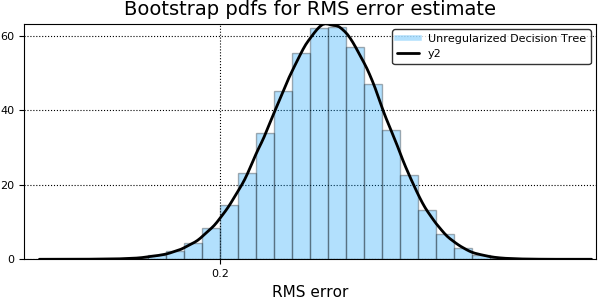

In [11]:
using Plots, ADBPlots
pyplot(size=(600,300))
bootstrap_histogram(errors, label="Unregularized Decision Tree")
plot!(xlab="RMS error", title="Bootstrap pdfs for RMS error estimate")


## Tuning a single parameter
Our decision trees have a regularization parameter `regularization` which, when non-zero, will arrange predictions at a leaf see values of the target for training patterns reaching nearby leaves. The larger the value of `regularization`, the more the prediction is affected by nearby leaves; when `regularization=0` the prediction is, as usual, the average of all target values of training patterns that reach the same leaf as the input pattern. 

To optimize `regularization` we shall make use of a convenient macro, @getfor from the ADBUtilities module. (An alternative to the ScikitLearn gridsearch function, which can also be imported.) The code,

    @getfor var range code 

evaluates `code`, replacing appearances of `var` therein with each value in `range`. The `range` and corresponding evaluations are returned as a tuple of arrays, which is convenient for plotting. For example,

    @getfor  x 1:3 (x^2 + 1)

evaluates to 

    ([1,2,3], [2, 5, 10])

In [13]:
u, v = @getfor ρ linspace(0.75,0.99,20) cv_error(TreeRegressor(regularization=ρ),
X, y, full, verbose=false)

([0.75,0.762632,0.775263,0.787895,0.800526,0.813158,0.825789,0.838421,0.851053,0.863684,0.876316,0.888947,0.901579,0.914211,0.926842,0.939474,0.952105,0.964737,0.977368,0.99],[0.176501,0.175908,0.175346,0.174819,0.17433,0.173884,0.173487,0.173141,0.172852,0.172624,0.17246,0.172364,0.172338,0.172384,0.172505,0.172701,0.17297,0.173313,0.173728,0.174211])


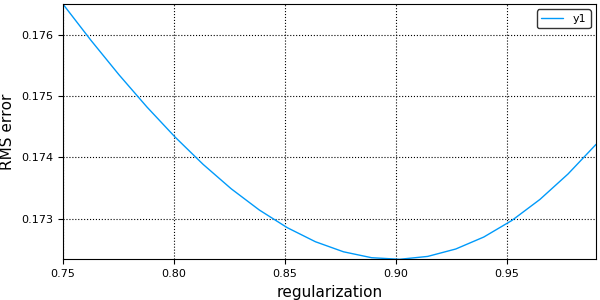

In [14]:
plot(u,v; xlab="regularization", ylab="RMS error")

fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,fold 11,fold 12,



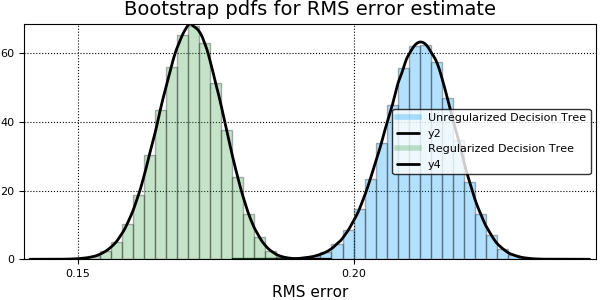

In [15]:
tree.regularization=0.9
errors_reg=cv_errors(tree, X, y, full, n_folds=12)
bootstrap_histogram(errors, label="Unregularized Decision Tree")
bootstrap_histogram!(errors_reg, label="Regularized Decision Tree")
plot!(xlab="RMS error", title="Bootstrap pdfs for RMS error estimate")

Evidentally, a statistically signicant improvement.
## Bagged regressors
A regressor type called `BaggedRegressor`, allows one to apply Breiman's bagging technique to obtain an ensemble of regressors of any fixed type; each member of the ensemble is a clone of some instance `atom`. A random forest (with standard bagging) is obtained as a special case:"

In [16]:
tree = TreeRegressor(max_features=3)
forest = BaggedRegressor(X,y,train; atom=tree, n=20)


Now cloning and fitting regressor number: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,


BaggedRegressor{Regressors.TreeRegressor}@...4554

Training can be parallelized:

In [17]:
forest = BaggedRegressor(X,y,train; atom=TreeRegressor(), n=20, parallel=true)

Ensemble-building in parallel on 3 processors.
	From worker 2:	
	From worker 3:	
	From worker 4:	
	From worker 3:	Now cloning and fitting regressor number: 1,2,3,4,5,6,
	From worker 2:	Now cloning and fitting regressor number: 1,2,3,4,5,6,
	From worker 4:	Now cloning and fitting regressor number: 1,2,3,4,5,6,7,8,


BaggedRegressor{Regressors.TreeRegressor}@...6320

In [18]:
forest.n_iter

20

We can add more trees to the ensemble:

In [19]:
add!(forest, X, y, train; n=10, parallel=true)

Ensemble-building in parallel on 3 processors.
	From worker 2:	
	From worker 3:	
	From worker 4:	
	From worker 3:	Now cloning and fitting regressor number: 1,2,3,
	From worker 2:	Now cloning and fitting regressor number: 1,2,3,
	From worker 4:	Now cloning and fitting regressor number: 1,2,3,4,


BaggedRegressor{Regressors.TreeRegressor}@...6320

In [20]:
forest.n_iter

30

And compute a learning curve to the determine number of iterations required for convergence (by default the RMS error is used):

In [21]:
iters_to_plot = 1:5:100
curve = learning_curve(forest, X, y, train, valid, iters_to_plot; 
    parallel=true, verbose=false, )

([1.0,6.0,11.0,16.0,21.0,26.0,31.0,36.0,41.0,46.0,51.0,56.0,61.0,66.0,71.0,76.0,81.0,86.0,91.0,96.0],[0.229194,0.170244,0.166117,0.162641,0.160977,0.161402,0.160652,0.159567,0.158597,0.157668,0.157242,0.157549,0.157086,0.157057,0.157464,0.158167,0.158095,0.158249,0.157841,0.158233])


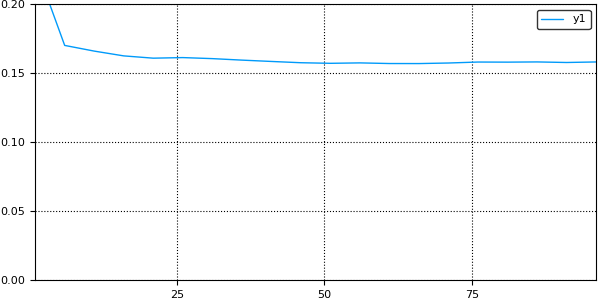

In [22]:
plot(curve, ylim=(0,0.2))

Or plot several such curves:


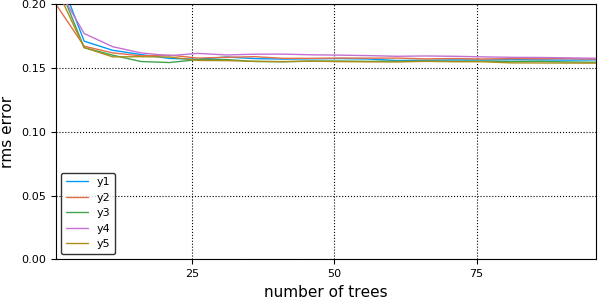

In [23]:
plt=plot(;xlab="number of trees", ylab="rms error", ylim=(0,0.2));
for _ in 1:5
    plot!(learning_curve(forest, X, y, train, valid, iters_to_plot, verbose=false))
end
plt

## Tuning the random forest parameters
We now train `max_features` and `min_patterns_split` with a two-variable version of the `@getfor` macro (for details, check the docstring with `?@getfor`). For fine tuning we will use cross-validation.


In [24]:
u,v,w = @getfor maxf 1:11 minp 2:5 rms_error(
    BaggedRegressor(X, y, train, 
        atom = TreeRegressor(max_features=maxf, min_patterns_split=minp),
        n=200, parallel=true, verbose=false), 
    X, y, valid);

In [25]:
labels = map(v) do x
    string("min_patterns_split=",x)
end

1×4 Array{String,2}:
 "min_patterns_split=2"  "min_patterns_split=3"  …  "min_patterns_split=5"


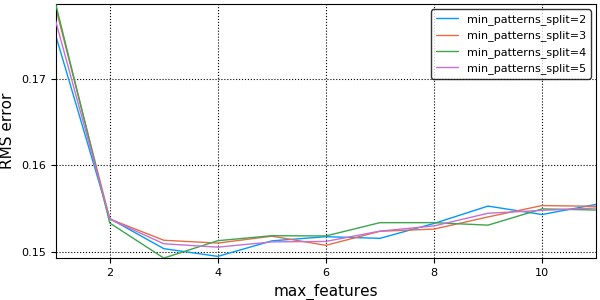

In [26]:
plot(u, w, label=labels, xlab="max_features", ylab="RMS error")

And now for the fine tuning:

In [27]:
u,v,w = @getfor maxf 2:5 minp 2:5 cv_error(
    BaggedRegressor(atom=TreeRegressor(max_features=maxf, min_patterns_split=minp), n=200), 
    X, y, full, verbose=false, parallel=true, n_folds=9);


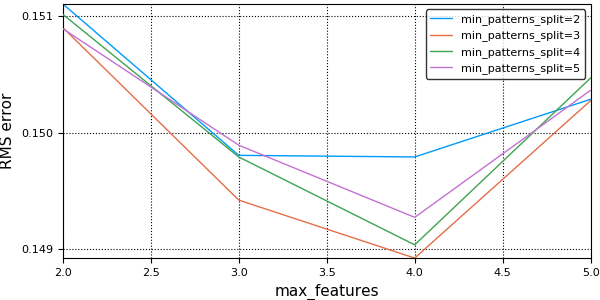

In [27]:
labels=map(v) do x
    string("min_patterns_split=",x)
end
plot(u,w,label=labels,xlab="max_features",ylab="RMS error")

Distributing cross-validation computation among 3 workers.



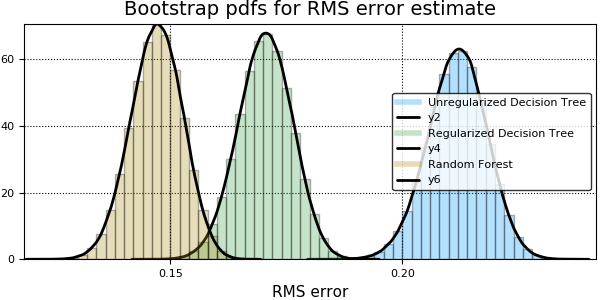

In [30]:
tree = TreeRegressor(max_features=4 , min_patterns_split=3)
forest = BaggedRegressor(atom=tree, n=500)
errors_rf=cv_errors(forest, X, y, full, n_folds=12, parallel=true, verbose=false)
bootstrap_histogram(errors, label="Unregularized Decision Tree")
bootstrap_histogram!(errors_reg, label="Regularized Decision Tree")
bootstrap_histogram!(errors_rf, label="Random Forest")
plot!(xlab="RMS error", title="Bootstrap pdfs for RMS error estimate")

Here is an approximate 95% confidence interval for the RMS error of our best model:

In [31]:
string(mean(errors_rf), " ± ", 2*std(errors_rf))

"0.1470035805386954 ± 0.040348106349863105"